In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import nltk
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from nltk import everygrams
from nltk.stem import WordNetLemmatizer

# 1. Import Data

The file 'cleaned_train.csv' was created from previuos calculations.

In [2]:
df = pd.read_csv('cleaned_train.csv', index_col=0)
df.head()

,lat,long,new_keyword,word_number,tags_number,hashtags_number,url_number,text,target
0,360.0,360.0,NaN,13,0,1,0,Our Deeds are the Reason of this #earthquake M...,1
1,360.0,360.0,NaN,7,0,0,0,Forest fire near La Ronge Sask. Canada,1
2,360.0,360.0,NaN,22,0,0,0,All residents asked to 'shelter in place' are ...,1
3,360.0,360.0,NaN,9,0,1,0,"13,000 people receive #wildfires evacuation or...",1
4,360.0,360.0,NaN,17,0,2,0,Just got sent this photo from Ruby #Alaska as ...,1


For the future preprocessing I will copy functions I used for preprocessing.

In [3]:
unknownlocs = {"CLVLND".lower(): "Cleveland",
               "EPTX".lower(): "El Paso, Texas",
               "ChicagoRObotz".lower(): "Chicago",
               "SWMO".lower(): "Southwest Missouri",
               "Selma2Oakland".lower(): "Oakland",
               "BestCoast".lower(): "West Coast",
               "soooota".lower().lower(): "Minnesota",
               "USAoV".lower(): "United States",
               "RhodeIsland".lower(): "Rhode Island",
               "NYHC".lower(): "New York",
               "houstn".lower(): "Houston",
               "NIFC".lower(): "Boise, Idaho",
               "EastCarolina".lower(): "East Carolina",
               "Bhubneshwar".lower(): "Bhubaneswar, India",
               "RedSoxNation".lower(): "Boston",
               "texasss".lower(): "Texas",
               "Flipadelphia".lower(): "Philadelphia",
               "Londonstan".lower(): "London, UK",
               "scumbernauld".lower(): "Cumbernauld, Scotland",
               "L A".lower(): "Los Angeles",
               "IN".lower(): "Indianapolis",
               "MA".lower(): "Massachusetts"}

spam = ["World Wide", "Live On Webcam", "Milky Way", "In Progress", "Your Sister S Bedroom","Instagram", "Global", "We Know",
       "Show", "News And Views", "Y Our", "Out There", "A U S Resident", "With 2 Kids", "Youtube Channel", "Own Zone", "Ig", 
        "ss", "ANYWEHERE", "Blogland", "Earthling For now", "Fakefams", "WORDLDWIDE", 
        "Live4Heed", "Yooooooo", "WorldWideWeb", "Here", "buhh", "Reddit", "InterplanetaryZone","Hustletown"]
spam = [w.lower() for w in spam]

In [4]:
emailregex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
stop_words = stopwords.words('english')
geolocator = Nominatim(user_agent="My NLP Program")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def location_cleaning(string):
    if pd.isna(string) or re.fullmatch(emailregex, string) or re.match(r"[0-9]+", string):
        return np.nan, np.nan
    #coordinates
    string = re.sub(' +', ' ', re.sub(r",", ", ", string))
    lst = string.split(", ")
    if len(lst) == 2:
        try:
            return float(lst[0]), float(lst[1])
        except ValueError:
            pass
    string = re.sub(' +', ' ', re.sub(r'[^a-zA-Z0-9]', ' ', string))
    lst = [w for w in word_tokenize(string.lower())]
    lst = [w for w in lst if w.lower() not in stop_words]
    lst = list(everygrams(lst))
    for tpl in lst[::-1]:
        last_str = (" ".join(tpl)).lstrip(" ").rstrip(" ")
        #print(last_str)
        last_str = unknownlocs.get(last_str, last_str)
        if last_str.lower() in spam or last_str == " ": 
            return np.nan, np.nan
        location = geocode(last_str)
        if location is not None:
            return location.latitude, location.longitude
    #print(string)
    return np.nan, np.nan

In [5]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yulia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yulia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yulia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yulia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
lemmatizer = WordNetLemmatizer()

def get_new_keyword(x):
    if pd.isna(x):
        return x
    new_str = []
    #print(pos_tag(word_tokenize(x)))
    for word, tag in pos_tag(word_tokenize(x)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        if not wntag:
            lemma = word
        else:
            lemma = lemmatizer.lemmatize(word, wntag)
        new_str.append(lemma)
    return " ".join(new_str)

In [7]:
df1 = df
df1['new_keyword'] = df.new_keyword.apply(get_new_keyword)
df1.new_keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilate', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'avalanche',
       'battle', 'bioterror', 'bioterrorism', 'blaze', 'blazing',
       'bleeding', 'blow up', 'blight', 'blizzard', 'blood', 'bloody',
       'body bag', 'bomb', 'bombed', 'bombing', 'bridge collapse',
       'building burning', 'building on fire', 'burn', 'burning',
       'burn building', 'bush fire', 'casualty', 'catastrophe',
       'catastrophic', 'chemical emergency', 'cliff fall', 'collapse',
       'collide', 'collision', 'crash', 'crashed', 'crush', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'debris', 'deluge',
       'demolish', 'demolition', 'derail', 'derailment', 'desolate',
       'desolation', 'destroy', 'destroyed', 'destruction', 'detonate',
       'detonation', 'devastate', 'devastation', 'disaster', 'displace',
       'drought', 'drown', 'du

# 2. Tweets cleaning

In [8]:
df1["text_clean"] = df1["text"].apply(lambda x: x.lower())
df1['text_clean'] = df1['text_clean'].str.replace('@','')
df1['text_clean'] = df1['text_clean'].str.replace('#','')

df1['text_clean'] = df1['text_clean'].str.replace('[1-9]','')
df1['text_clean'] = df1['text_clean'].apply(lambda x: re.sub('[^a-zA-Z ./]','', x))
df1.text_clean

0       our deeds are the reason of this earthquake ma...
1                  forest fire near la ronge sask. canada
2       all residents asked to shelter in place are be...
3        people receive wildfires evacuation orders in...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610    m.  utckm s of volcano hawaii. http//t.co/zdto...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text_clean, Length: 7613, dtype: object

In [9]:
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

df1["text_clean"] = df1["text_clean"].apply(lambda x: remove_URL(x))

In [10]:
def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

df1["text_clean"] = df1["text_clean"].apply(lambda x: remove_html(x))

In [11]:
df1['text_clean'] = df1['text_clean'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [12]:
df1.new_keyword = df1.new_keyword.fillna("")

In [13]:
df1['tokens'] = [word_tokenize(item) for item in df1.text_clean]

In [14]:
df1.head(1)

,lat,long,new_keyword,word_number,tags_number,hashtags_number,url_number,text,target,text_clean,tokens
0,360.0,360.0,,13,0,1,0,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,"[deeds, reason, earthquake, may, allah, forgiv..."


In [15]:
# VECTORIZATION

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
df1["clean"] = df1.tokens.apply(lambda x: " ".join(x))
df1["clean"] = df1["clean"] + " " + df1.new_keyword
X = vectorizer.fit_transform(df1.clean)
X = pd.DataFrame(X.toarray())
y = df1['target']

X[["lat", "long", "word_number", "tags_number", "hashtags_number", "url_number"]] = df1[["lat", "long", "word_number", "tags_number", "hashtags_number", "url_number"]]
X

,0,1,2,3,4,5,6,7,8,9,...,21469,21470,21471,21472,lat,long,word_number,tags_number,hashtags_number,url_number
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.0,360.0,13,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.0,360.0,7,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.0,360.0,22,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.0,360.0,9,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.0,360.0,17,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.0,360.0,11,0,0,1
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.0,360.0,20,2,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.0,360.0,8,0,0,1
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.0,360.0,19,0,0,0


# Modeling Process

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [17]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(random_state = 0, max_iter = 5000)
log.fit(X_train, y_train)
log_pred = log.predict(X_test)

# Evaluation

In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score,KFold

acc = accuracy_score(y_test,log_pred)
print("ACCURACY : ",acc)

ACCURACY :  0.8135259356533159


In [19]:
kfold = KFold(n_splits=10)
results = cross_val_score(log, X, y,cv=kfold)
print("K-FOLD CROSS VALIDATION : ",results.mean())

K-FOLD CROSS VALIDATION :  0.7429299409190145


In [20]:
clf_report = classification_report(y_test,log_pred)
print("CLASSIFICATION REPORT:\n", clf_report)

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.81      0.88      0.85       886
           1       0.81      0.72      0.76       637

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



CONFUSION MATRIX:


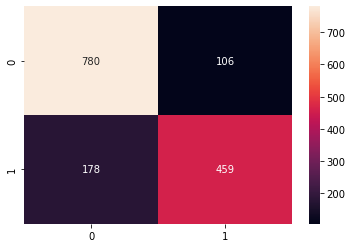

In [21]:
print("CONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_test,log_pred),annot=True,fmt='g')
plt.show()

# Prediction of the test data

In [22]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [23]:
test_df['lat'], test_df['long'] = zip(*test_df.location.apply(location_cleaning))

RateLimiter caught an error, retrying (0/2 tries). Called with (*('c',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\li

RateLimiter caught an error, retrying (0/2 tries). Called with (*('1',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\li

RateLimiter swallowed an error after 2 retries. Called with (*('1',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\lib\s

RateLimiter caught an error, retrying (0/2 tries). Called with (*('2',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\li

RateLimiter swallowed an error after 2 retries. Called with (*('2',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\lib\s

RateLimiter caught an error, retrying (1/2 tries). Called with (*('4',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\li

RateLimiter caught an error, retrying (0/2 tries). Called with (*('5 334943',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaco

RateLimiter swallowed an error after 2 retries. Called with (*('5 334943',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda

RateLimiter caught an error, retrying (1/2 tries). Called with (*('5',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\li

RateLimiter caught an error, retrying (0/2 tries). Called with (*('193556 5',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaco

RateLimiter swallowed an error after 2 retries. Called with (*('193556 5',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda

RateLimiter caught an error, retrying (1/2 tries). Called with (*('58 193556 5',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\An

RateLimiter caught an error, retrying (0/2 tries). Called with (*('58 193556',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anac

RateLimiter caught an error, retrying (0/2 tries). Called with (*('2',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\li

RateLimiter swallowed an error after 2 retries. Called with (*('2',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\lib\s

RateLimiter caught an error, retrying (1/2 tries). Called with (*('5',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\li

RateLimiter caught an error, retrying (0/2 tries). Called with (*('113 978785',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Ana

RateLimiter caught an error, retrying (1/2 tries). Called with (*('3 8793718',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anac

RateLimiter caught an error, retrying (0/2 tries). Called with (*('3',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\li

RateLimiter swallowed an error after 2 retries. Called with (*('3',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\lib\s

RateLimiter caught an error, retrying (1/2 tries). Called with (*('384559 3',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaco

RateLimiter caught an error, retrying (0/2 tries). Called with (*('7 384559 3',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Ana

RateLimiter swallowed an error after 2 retries. Called with (*('7 384559 3',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anacon

RateLimiter caught an error, retrying (1/2 tries). Called with (*('7 384559',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaco

RateLimiter caught an error, retrying (0/2 tries). Called with (*('7',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\li

RateLimiter swallowed an error after 2 retries. Called with (*('7',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\lib\s

RateLimiter caught an error, retrying (1/2 tries). Called with (*('1',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\li

RateLimiter caught an error, retrying (0/2 tries). Called with (*('brasil 1',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaco

RateLimiter swallowed an error after 2 retries. Called with (*('brasil 1',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda

RateLimiter caught an error, retrying (0/2 tries). Called with (*('9',), **{}).
Traceback (most recent call last):
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Program Files (x86)\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 1371, in getresponse
    response.begin()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files (x86)\Anaconda3\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files (x86)\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Program Files (x86)\Anaconda3\li

In [24]:
test_df.head()

,id,keyword,location,text,lat,long
0,0,NaN,NaN,Just happened a terrible car crash,NaN,NaN
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",NaN,NaN
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",NaN,NaN
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,NaN,NaN
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,NaN,NaN


In [25]:
test_df['new_keyword'] = test_df.keyword.apply(get_new_keyword)

In [26]:
test_df['tweet_len'] = test_df.text.apply(len)

In [27]:
test_df['word_number'] = test_df.text.apply(lambda x: len(x.split(" ")))

In [28]:
test_df['tags_number'] = test_df.text.apply(lambda x: len([tag for tag in x.split() if '@' in tag]))

In [29]:
test_df['hashtags_number'] = test_df.text.apply(lambda x: len([tag for tag in x.split() if '#' in tag]))

In [30]:
test_df['url_number'] = test_df.text.apply(lambda x: len([url for url in x.lower().split() 
                                                          if 'http' in url or 'https' in url or 'www' in url]))

In [31]:
new_test_df = test_df[['lat', 'long', 'new_keyword', 'word_number', 'tags_number','hashtags_number','url_number', 'text']]
new_test_df.head()

,lat,long,new_keyword,word_number,tags_number,hashtags_number,url_number,text
0,NaN,NaN,NaN,6,0,0,0,Just happened a terrible car crash
1,NaN,NaN,NaN,9,0,1,0,"Heard about #earthquake is different cities, s..."
2,NaN,NaN,NaN,19,0,0,0,"there is a forest fire at spot pond, geese are..."
3,NaN,NaN,NaN,4,0,2,0,Apocalypse lighting. #Spokane #wildfires
4,NaN,NaN,NaN,8,0,0,0,Typhoon Soudelor kills 28 in China and Taiwan


In [32]:
new_test_df["lat"][pd.isna(new_test_df.lat)] = 360.0
new_test_df["long"][pd.isna(new_test_df.long)] = 360.0
new_test_df["new_keyword"][pd.isna(new_test_df.new_keyword)] = ''

In [33]:
new_test_df.head()

,lat,long,new_keyword,word_number,tags_number,hashtags_number,url_number,text
0,360.0,360.0,,6,0,0,0,Just happened a terrible car crash
1,360.0,360.0,,9,0,1,0,"Heard about #earthquake is different cities, s..."
2,360.0,360.0,,19,0,0,0,"there is a forest fire at spot pond, geese are..."
3,360.0,360.0,,4,0,2,0,Apocalypse lighting. #Spokane #wildfires
4,360.0,360.0,,8,0,0,0,Typhoon Soudelor kills 28 in China and Taiwan


In [34]:
new_test_df["text_clean"] = new_test_df["text"].apply(lambda x: x.lower())
new_test_df['text_clean'] = new_test_df['text_clean'].str.replace('@','')
new_test_df['text_clean'] = new_test_df['text_clean'].str.replace('#','')

new_test_df['text_clean'] = new_test_df['text_clean'].str.replace('[1-9]','')
new_test_df['text_clean'] = new_test_df['text_clean'].apply(lambda x: re.sub('[^a-zA-Z ./]','', x))

In [35]:
new_test_df["text_clean"] = new_test_df["text_clean"].apply(lambda x: remove_URL(x))
new_test_df["text_clean"] = new_test_df["text_clean"].apply(lambda x: remove_html(x))
new_test_df['text_clean'] = new_test_df['text_clean'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [36]:
new_test_df['tokens'] = [word_tokenize(item) for item in new_test_df.text_clean]

In [37]:
new_test_df["clean"] = new_test_df.tokens.apply(lambda x: " ".join(x))
new_test_df["clean"] = new_test_df["clean"] + df1.new_keyword
X = vectorizer.transform(new_test_df.clean)
X = pd.DataFrame(X.toarray())

X[["lat", "long", "word_number", "tags_number", "hashtags_number", "url_number"]] = df1[["lat", "long", "word_number", "tags_number", "hashtags_number", "url_number"]]
X

,0,1,2,3,4,5,6,7,8,9,...,21469,21470,21471,21472,lat,long,word_number,tags_number,hashtags_number,url_number
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.000000,360.000000,13,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.000000,360.000000,7,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.000000,360.000000,22,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.000000,360.000000,9,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.000000,360.000000,17,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.000000,360.000000,12,0,0,2
3259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,38.725178,-105.607716,23,0,0,0
3260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,40.486444,-86.133635,9,0,0,0
3261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,360.000000,360.000000,23,0,2,0


In [38]:
y_res = log.predict(X)

# Submission

In [39]:
result = pd.read_csv('sample_submission.csv')
result.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [40]:
result.target = y_res

In [41]:
result.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [42]:
result.to_csv("submission.csv", index = False)

The Kaggle competition score: 0.77229